**Angie Carolina Joya  Duarte - 2322609**

**Emily Nuñez Ordoñez - 2240156**

**Hassen Ortiz Álvarez - 2177273**

Se importan las librerías necesarias y se configuran los parámetros de la librería matplotlib para que las gráficas que va a generar sean embebidas en el notebook

In [ ]:
import pandas as pd
import numpy as np
import h5py
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Se definen algunas variables relacionadas con las propiedades del conjunto de datos para ser utilizadas en funciones posteriores. El ancho y alto corresponden a la mitad de la resolución original de las imagenes del conjunto de datos, pues debido a limitaciones de Hardware no se pudieron procesar en su tamaño original.

In [ ]:
ancho = 160
alto = 129
canales = 3
pixeles = ancho*alto*canales
cantidadClases = 5
clases = ['Banano', 'Granada', 'Kiwi', 'Mango', 'Pitaya']
batchSize = 64

Importamos el conjunto de datos de entrenamiento y de prueba, el cuál se llama Fruit Recognition y se puede encontrar en el siguiente enlace: https://www.kaggle.com/datasets/chrisfilo/fruit-recognition. Las impagenes importadas son transformadeas en tensores

El conjunto de datos se modifica para este ejercicio. Originalmente contiene 44.406 imágenes a color de 320×258 pixeles, clasificadas en 25 clases. Para este proyecto se seleccionaron 5 clases: Banano, Granada, Kiwi, Mango y Pitaya; Para cada clase se seleccionaron 1500 imágenes para el entrenamiento y 500 imágenes para las pruebas, obteniendo en total 7500 imágenes de entenamiento y 2500 de prueba. También se 

Durante la importación se define el atributo barajar (shuffle) como verdadero, esto permite que las imágenes sean cargadas en un orden aleatorio para que el modelo no tome en cuneta el orden de los datos en sus predicciones.

Además, se realiza la normalización de los valores para que estén centrados en torno a un valor promedio específico, en este caso estarían centrados alrededor de 0 y variarían en un rango aproximado de (−1,1). Esto ayuda a acelerar el entrenamiento, mejorar la convergencia y aumentar la consistencia entre los datos.

In [ ]:
transform = transforms.Compose([transforms.Resize((ancho, alto)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Train')
trainset = ImageFolder(root=dataset_path, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True)

testset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Test')
testset = ImageFolder(root=testset_path, transform=transform)
testloader = DataLoader(testset, batch_size=batchSize, shuffle=True)

Se define la función view_classify, que nos permitirá graficar la probabilidad de las clases para nuestras predicciones. Esta función es una modificación de la función que se encuentra en el archivo helper.py del repositorio guía https://github.com/udacity/deep-learning-v2-pytorch/tree/master/intro-to-pytorch

In [ ]:
def view_classify(img, ps):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(16,13), ncols=2)
  ax1.imshow(img.numpy().transpose((1, 2, 0)))
  ax1.axis('off')
  ax2.barh(np.arange(cantidadClases), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(cantidadClases))
  ax2.set_yticklabels(clases, size='medium');
  ax2.set_title('Probabilidad de las Clases')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

In [ ]:
def plot_confusion_matrix(cm, class_names, title="Matriz de Confusión"):
  fig, ax = plt.subplots(figsize=(6, 6))
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  plt.colorbar(cax)

  for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

  ax.set_xticks(np.arange(len(class_names)))
  ax.set_yticks(np.arange(len(class_names)))
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  plt.xlabel('Predicción')
  plt.ylabel('Real')
  plt.title(title)
  plt.show()

Paper: https://doi.org/10.3390/electronics12143132

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(pixeles, 20640)
    self.fc2 = nn.Linear(20640, 6880)
    self.fc3 = nn.Linear(6880, 2293)
    self.fc4 = nn.Linear(2293, 764)
    self.fc5 = nn.Linear(764, 254)
    self.fc6 = nn.Linear(254, 84)
    self.fc7 = nn.Linear(84, cantidadClases)
    self.dropout = nn.Dropout(p=0.5)
      
  def forward(self, x):
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.log_softmax(self.fc7(x), dim=1)
    
    return x

In [ ]:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
image, label = next(iter(trainloader))

In [ ]:
epochs = 40
steps = 0
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        all_labels = []
        all_preds = []
        
        # Turn off gradients for validation
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                # Save labels and predictions
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(top_class.cpu().numpy())
        
        # Calculate overall confusion matrix
        cm = confusion_matrix(all_labels, all_preds)

        # Calculate metrics for each class
        num_classes = cm.shape[0]
        precisions, recalls, f1_scores, accuracies, specificities = [], [], [], []
        for i in range(num_classes):
            tp = cm[i, i]
            fn = cm[i, :].sum() - tp
            fp = cm[:, i].sum() - tp
            tn = cm.sum() - (tp + fn + fp)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Calculate weighted metrics for the overall model
        precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        accuracy = accuracy_score(all_labels, all_preds)
        avg_specificity = np.mean(specificities)

        model.train()
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
        precisions.append(precision_weighted)
        recalls.append(recall_weighted)
        f1_scores.append(f1_weighted)
        accuracies.append(accuracy)
        specificities.append(avg_specificity)

        # Print metrics
        print("\nEpoch: {}/{}.. ".format(e + 1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy),
              "Weighted Precision: {:.3f}".format(precision_weighted),
              "Weighted Recall: {:.3f}".format(recall_weighted),
              "Weighted F1 Score: {:.3f}".format(f1_weighted),
              "Average Specificity: {:.3f}".format(avg_specificity))
        
        # Plot confusion matrix only on the last epoch
        if e == epochs - 1:
            print("\nMatriz de Confusión")
            plot_confusion_matrix(cm, clases, title="Matriz de Confusión")

KeyboardInterrupt: 

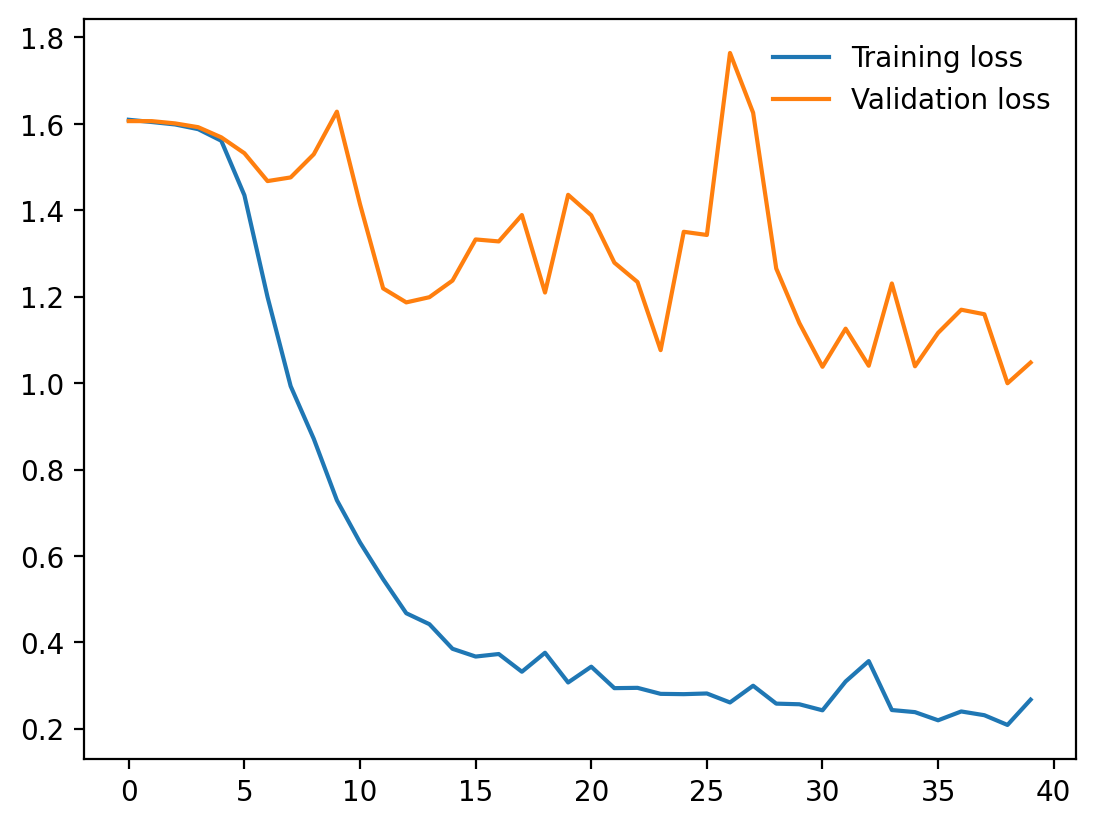

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

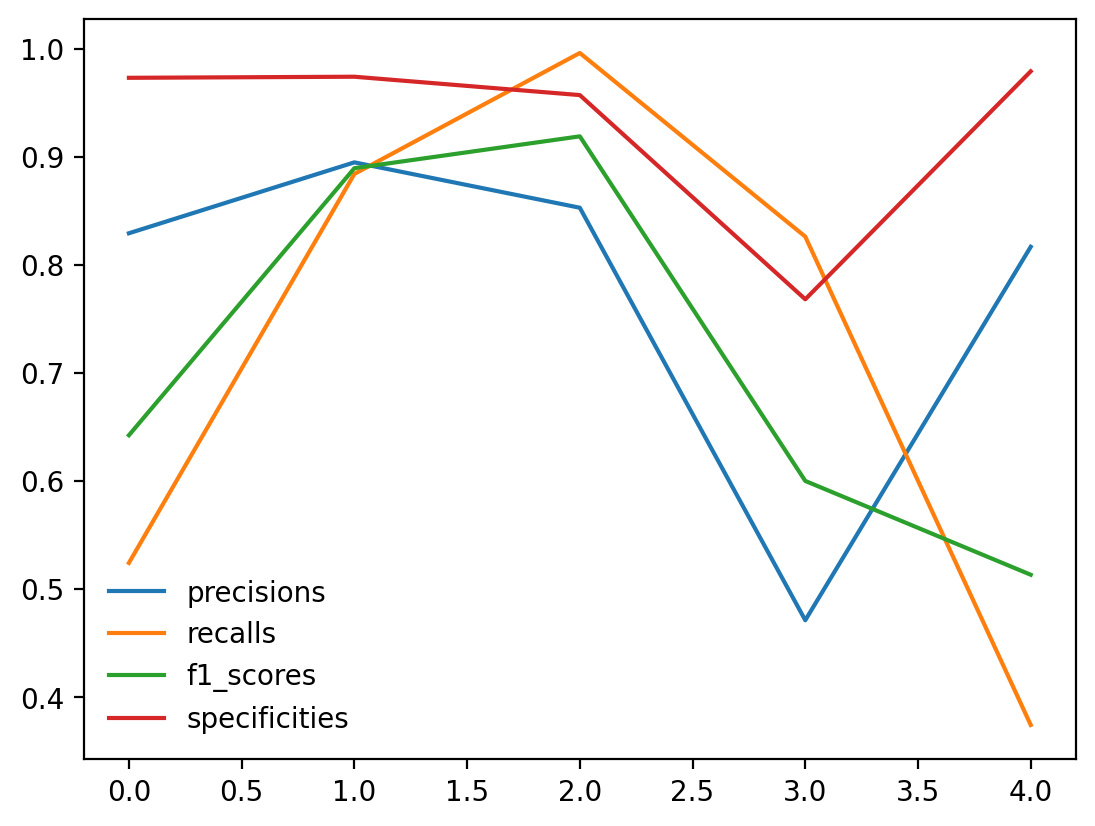

In [ ]:
plt.plot(precisions, label='precisions')
plt.plot(recalls, label='recalls')  
plt.plot(f1_scores, label='f1_scores')  
plt.plot(specificities, label='specificities')  
plt.legend(frameon=False)

In [ ]:
torch.save(model.state_dict(), 'modeloFinal1.pth')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


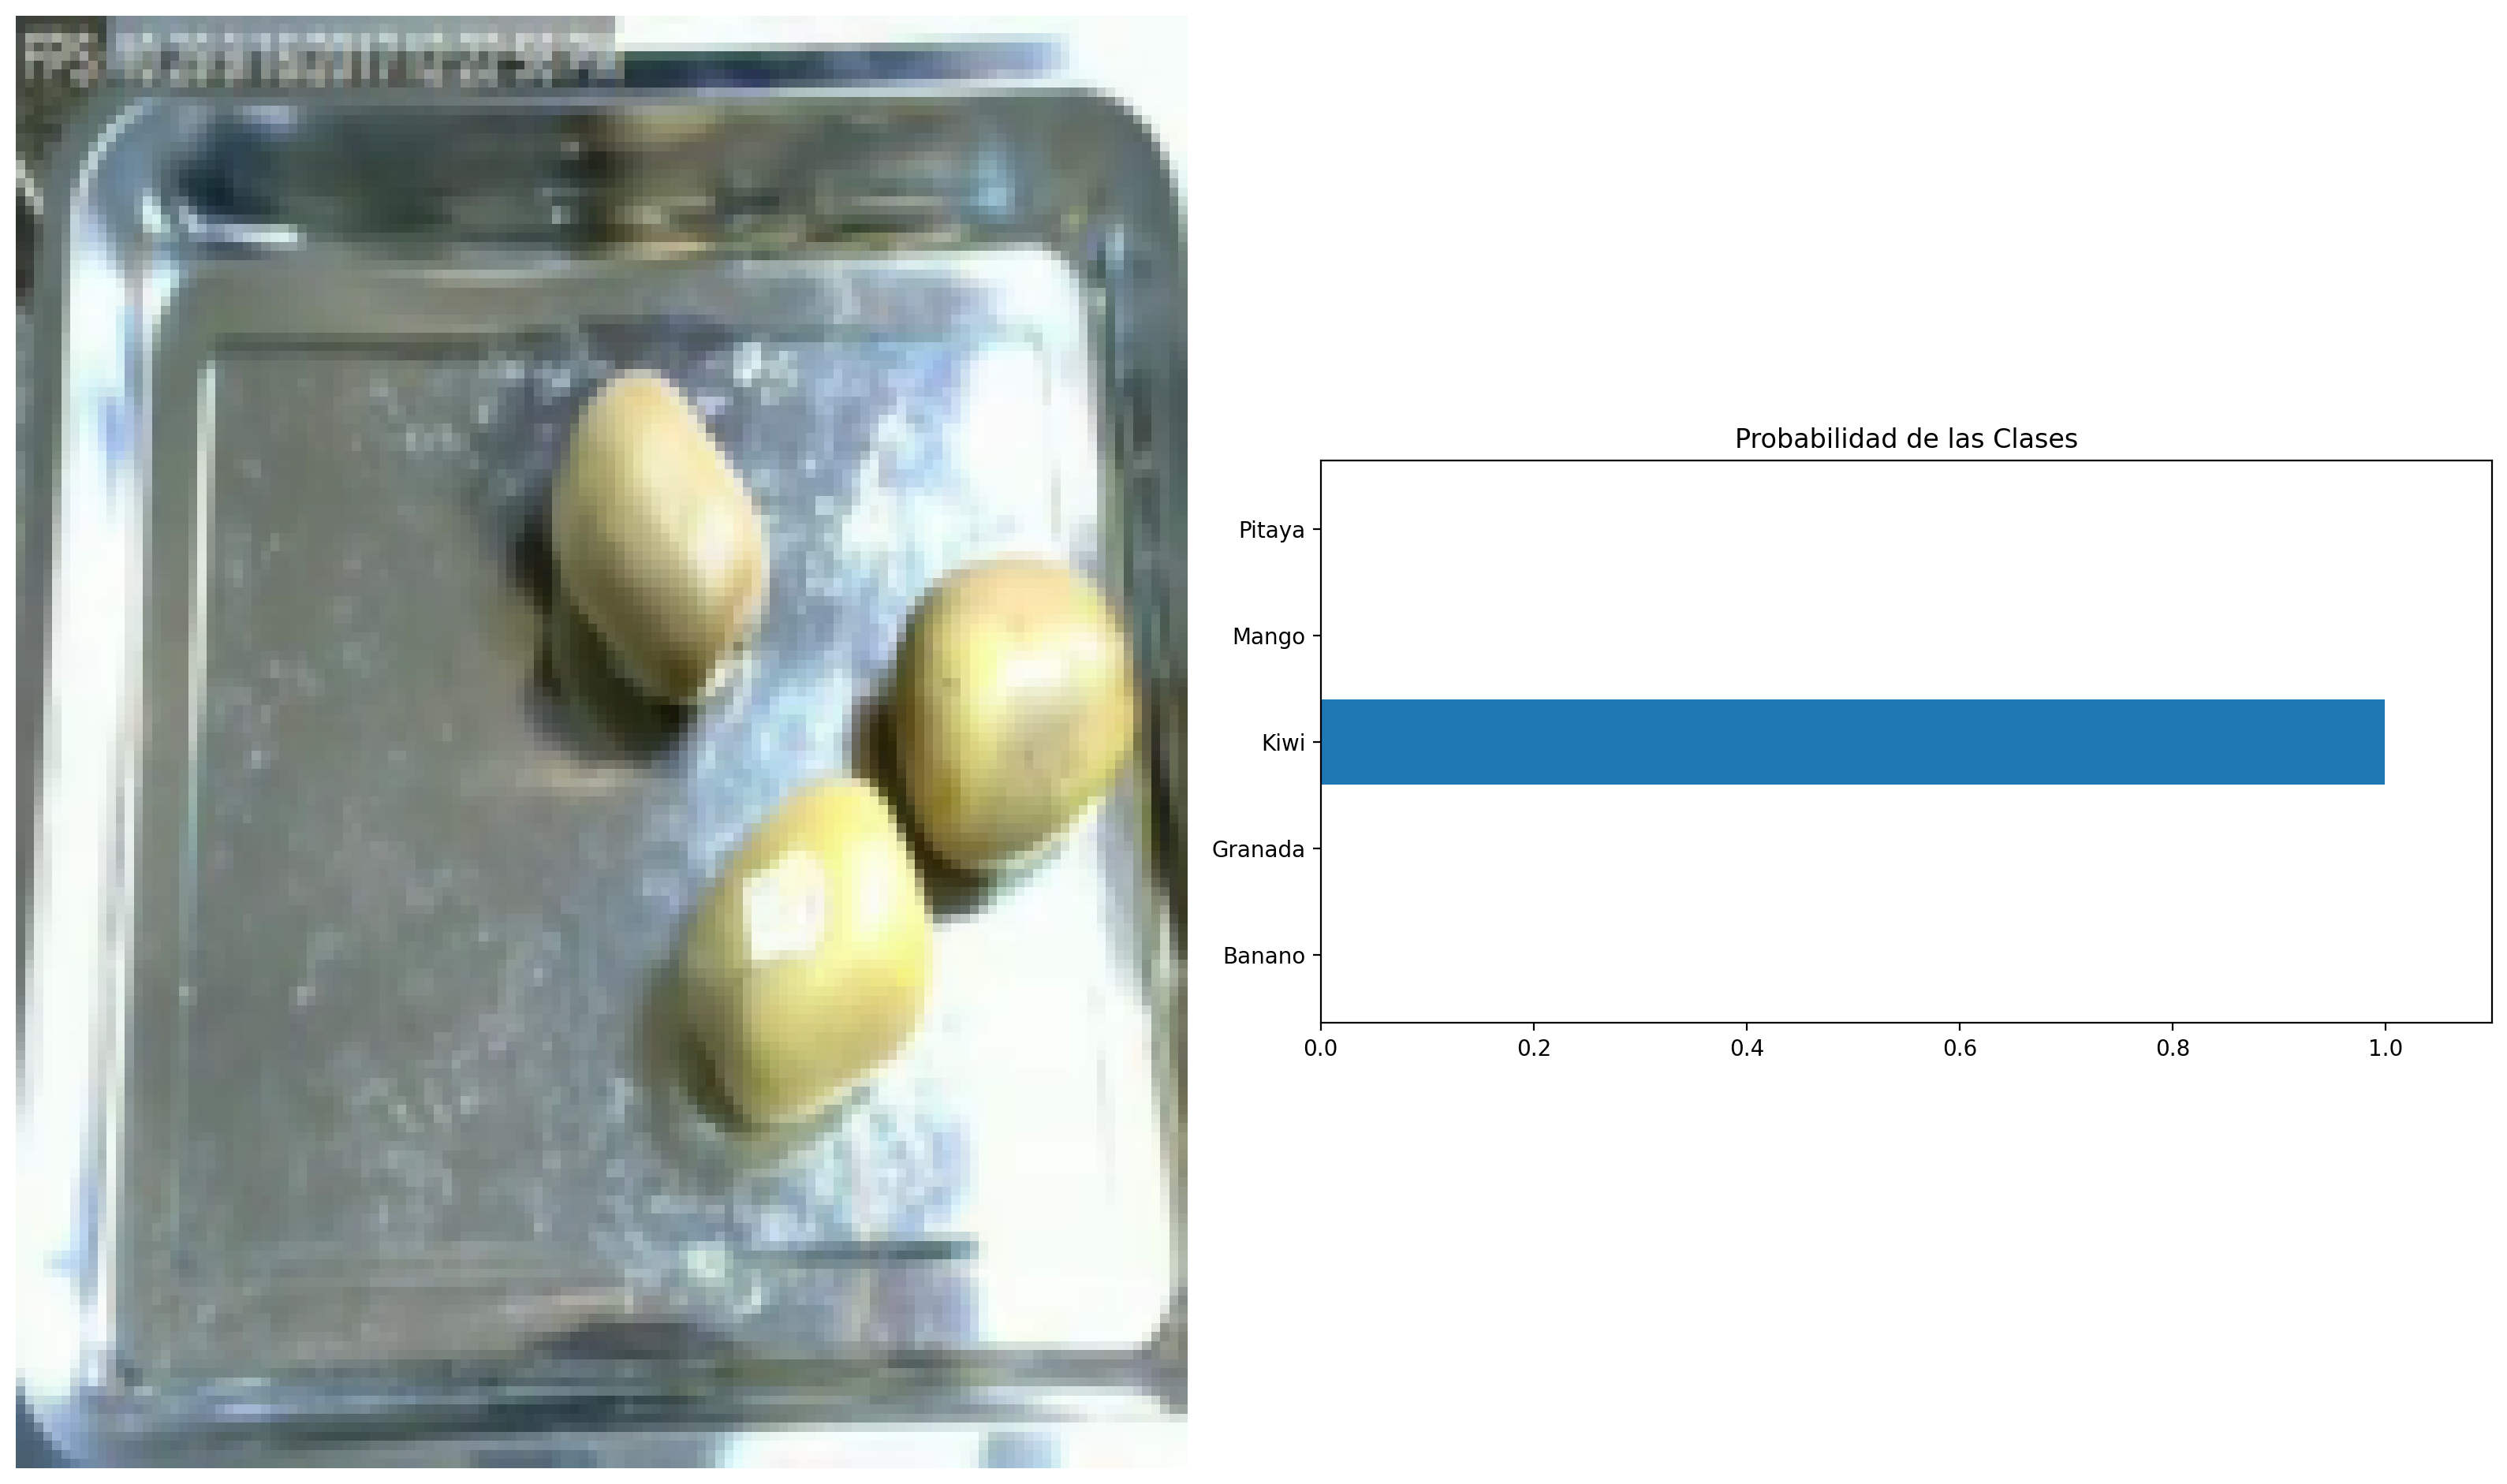

In [ ]:
dataiter = iter(testloader)
images, labels = next(iter(testloader))
img = images[0].view(1, pixeles)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img.view(canales, ancho, alto), ps)

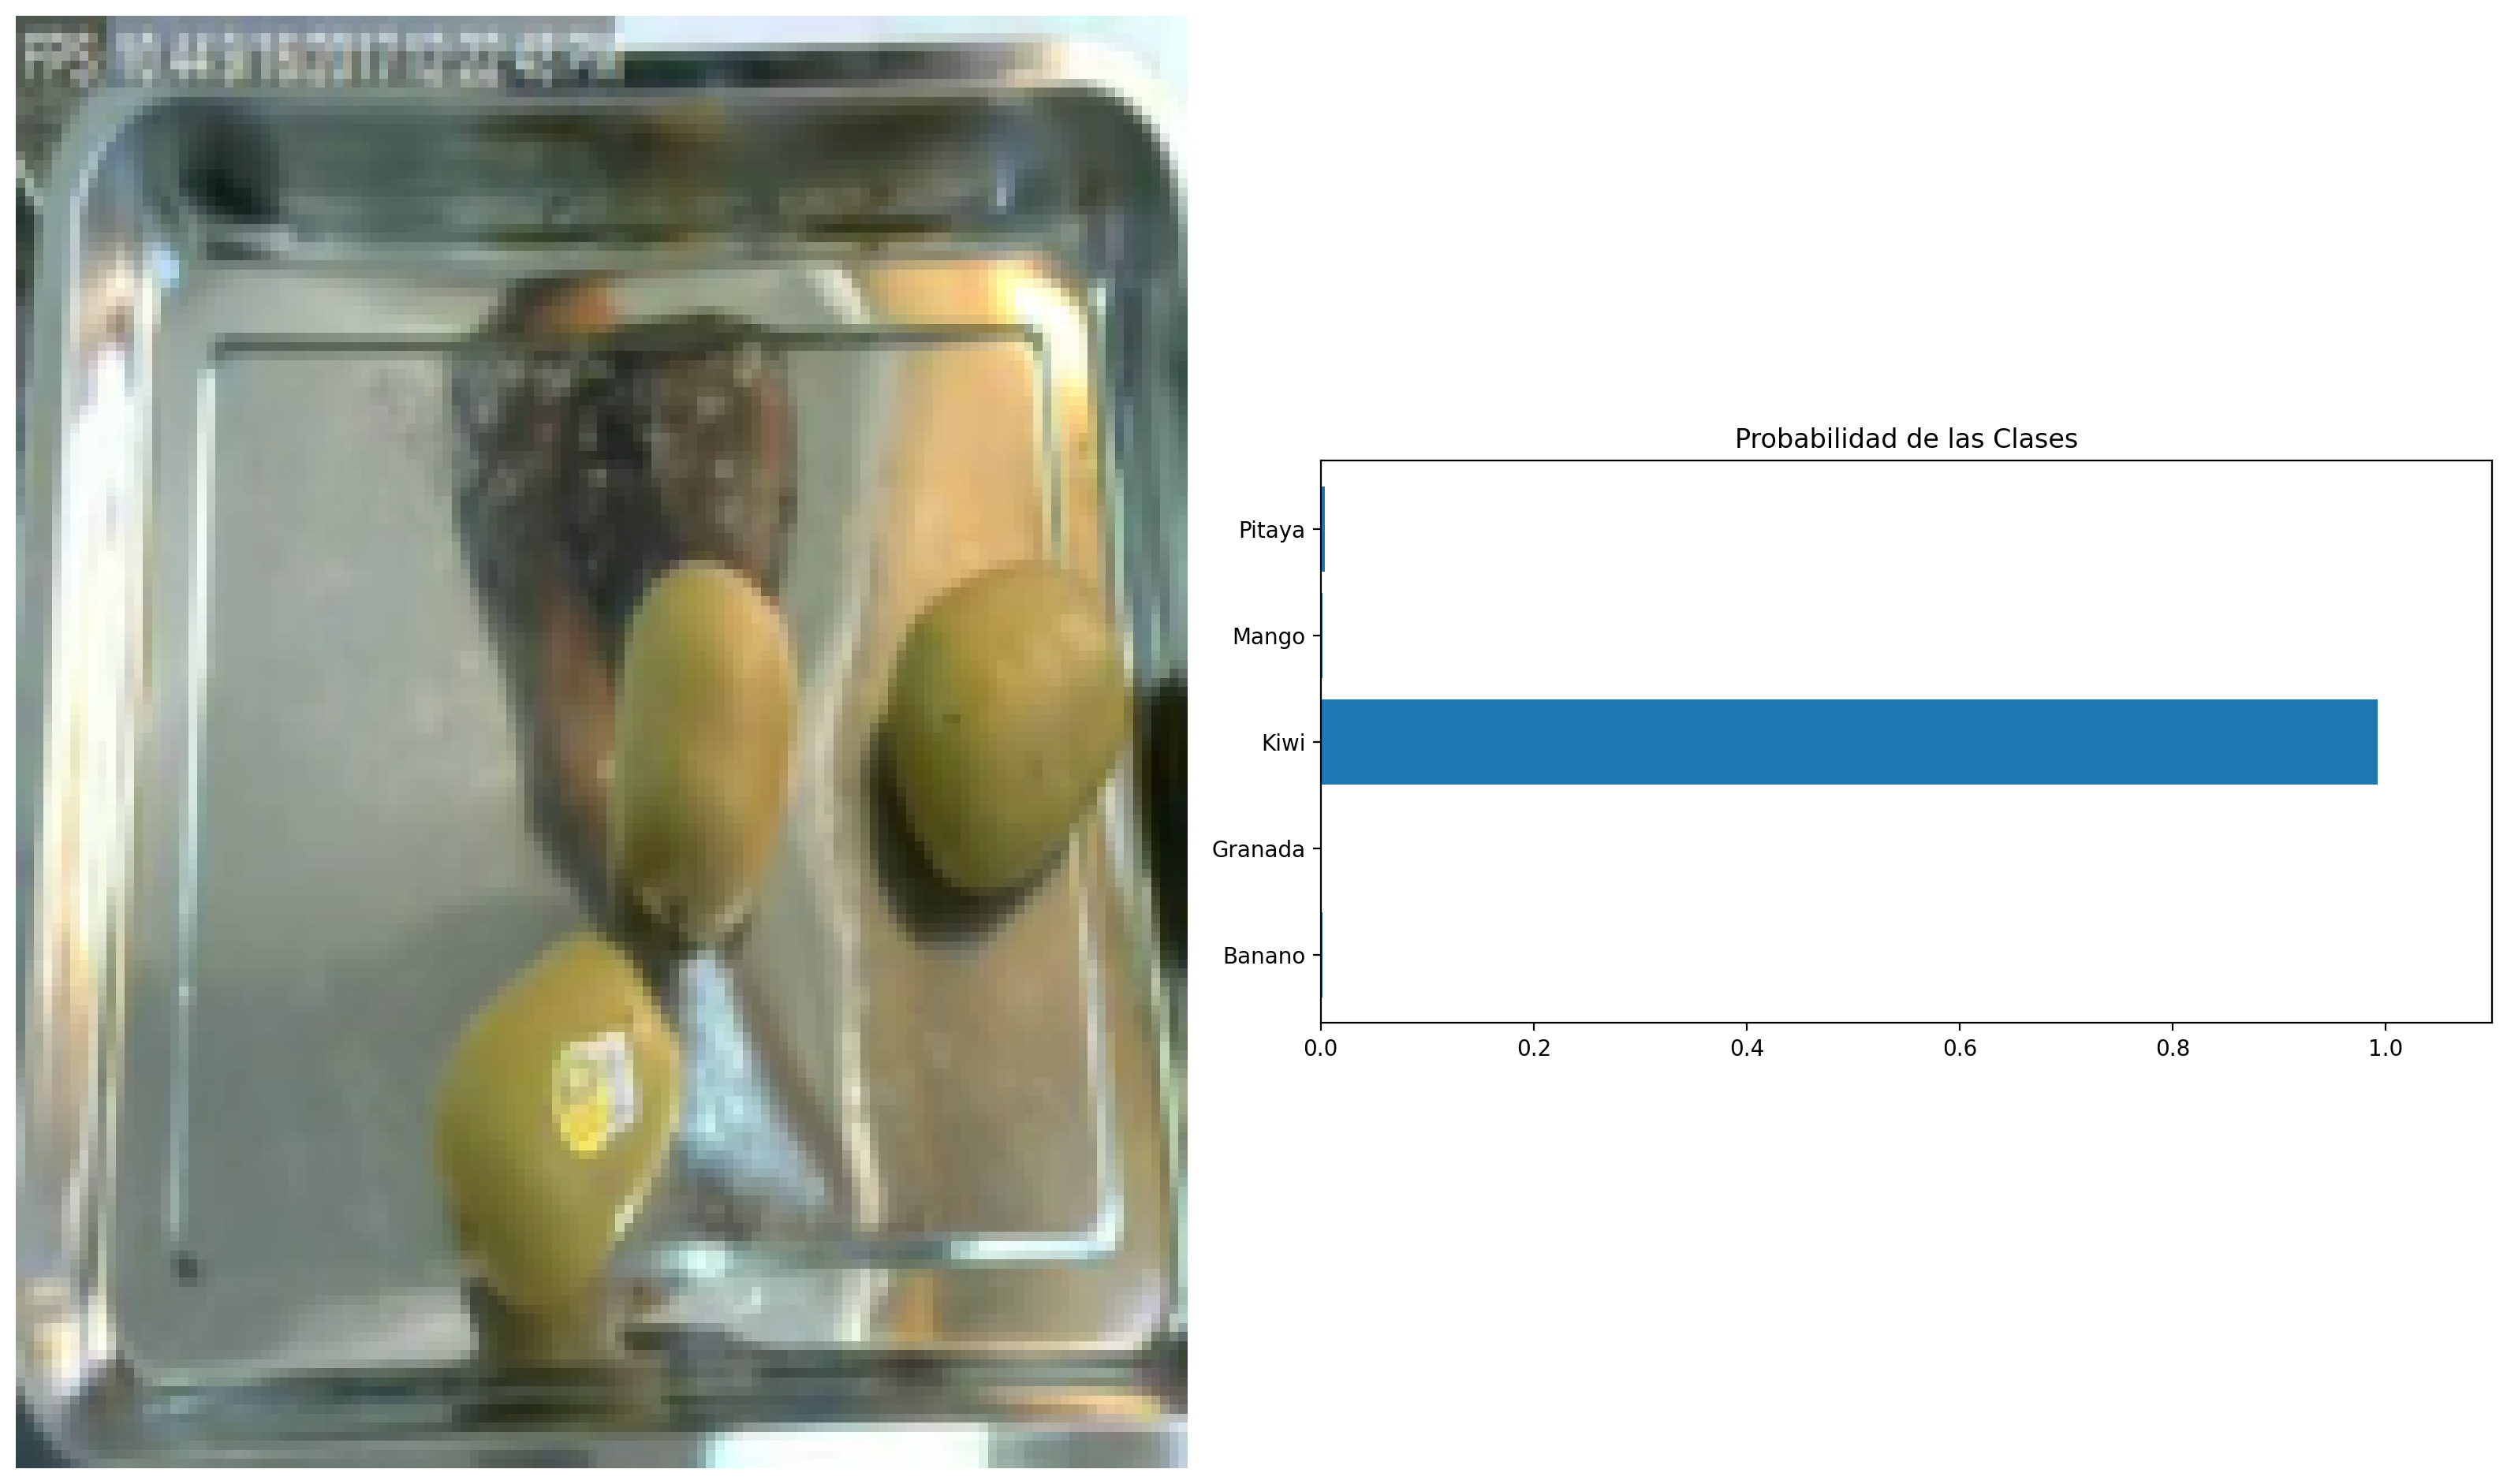

In [ ]:
import random
img = images[random.randrange(0,64)].view(1, pixeles)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img.view(canales, ancho, alto), ps)